In [1]:
import cv2
import numpy as np
import math
import math
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import random
import core

In [2]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    
def mycompare(a, b):
    index = 0
    size = a.shape
    for x, y in zip(a, b):
        if x==y:
            index += 1
    return index/size[0]

def test_model(dataloader, model):
    size = len(dataloader.dataset)
    # num_batches = len(dataloader)
    model.eval()
    correct = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    correct /= size
    print(f"Accuracy: {(100 * correct):>0.2f}%\n")
    
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
setup_seed(666)

Using cuda device


# 加载演示模型：resnet50-CIFAR10

In [3]:
target_model = core.models.ResNet(50)
target_model.to(device)
target_model.load_state_dict(torch.load('./tests/experiments/ResNet-50_CIFAR-10/ckpt_epoch_100.pth'))

<All keys matched successfully>

# 加载演示数据集：CIFAR10

In [4]:
batch_size = 1 
tr_transformer = transforms.Compose([
    # transforms.RandomCrop(32, padding=4),  # 先四周填充0，在吧图像随机裁剪成32*32
    # transforms.RandomHorizontalFlip(),  # 图像一半的概率翻转，一半的概率不翻转
    transforms.ToTensor(),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # R,G,B每层的归一化用到的均值和方差
])
te_transformer = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # R,G,B每层的归一化用到的均值和方差
])
training_data = datasets.CIFAR10(root='./datasets', train=True, download=True, transform=te_transformer)
test_data = datasets.CIFAR10(root='./datasets', train=False, download=True, transform=te_transformer)
train_dataloader = DataLoader(training_data, batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


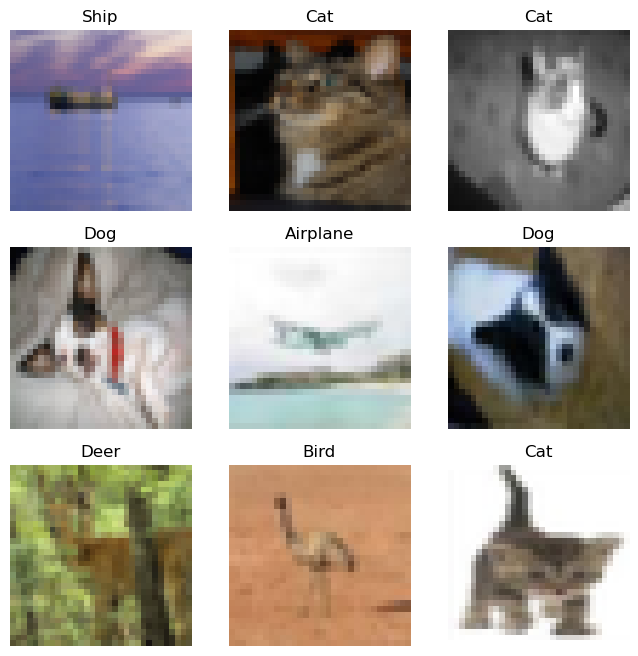

torch.Size([9, 3, 32, 32])


In [5]:
import matplotlib.pyplot as plt
labels_map = {
    0: "Airplane",
    1: "Automobile",
    2: "Bird",
    3: "Cat",
    4: "Deer",
    5: "Dog",
    6: "Frog",
    7: "Horse",
    8: "Ship",
    9: "Truck",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    if i==1:
        Original_img = torch.unsqueeze(img,dim=0)
    else:
        Original_img = torch.cat((Original_img,torch.unsqueeze(img,dim=0)),0)
    img = img.permute(1,2,0)
    plt.imshow(img.squeeze())
plt.show()
print(Original_img.shape)

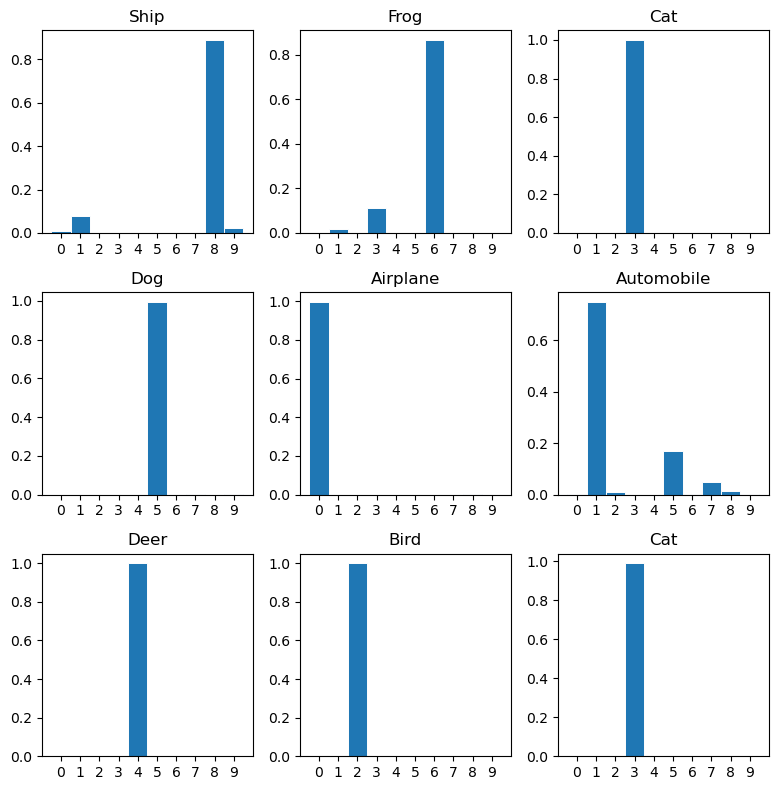

In [6]:
soft_max = nn.Softmax(dim=1)
l_x = ['0','1','2','3','4','5','6','7','8','9']
yticks = np.linspace(0, 1., 5)
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
pred = target_model(Original_img.to(device))
Original_label_value = soft_max(pred).detach().cpu().numpy()
Original_label = soft_max(pred).argmax(1).detach().cpu().numpy()
for i in range(1, cols * rows + 1):
    label = Original_label[i-1]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
#     plt.axis("off")
    yticks = np.linspace(0, 1., 5)
    plt.tight_layout()
    plt.bar(l_x, Original_label_value[i-1], width=1, edgecolor="white", linewidth=0.7)
plt.show()

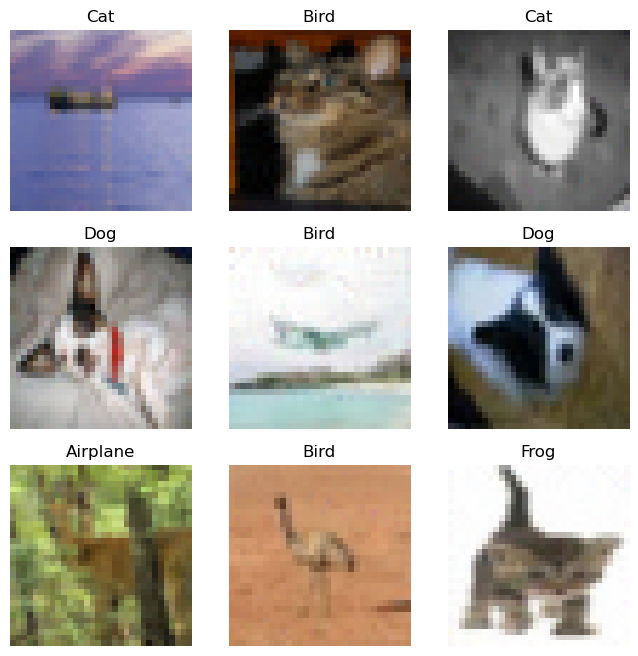

In [7]:
soft_max = nn.Softmax(dim=1)
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
Fragile_img = torch.load('./samples/cifar10/demonstrate_img')
# print(Fragile_img.shape)
Fragile_label = torch.load('./samples/cifar10/demonstrate_label')
# print(Fragile_label)
Fragile_img = Fragile_img.detach().cpu()
Fragile_label = soft_max(Fragile_label).argmax(1).detach().cpu().numpy()
# print(Fragile_label.shape)
for i in range(1, cols * rows + 1):
    img = Fragile_img[i-1]
    label = Fragile_label[i-1]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    img = img.permute(1,2,0)
    plt.imshow(img.squeeze())
plt.show()

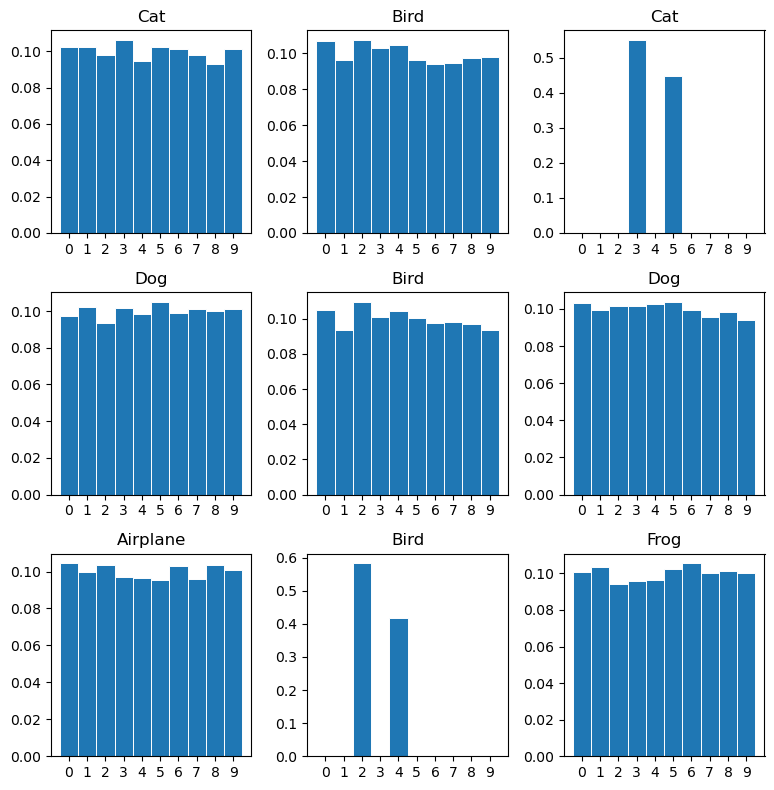

In [8]:
soft_max = nn.Softmax(dim=1)
l_x = ['0','1','2','3','4','5','6','7','8','9']
yticks = np.linspace(0, 1., 5)
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
Fragile_label = torch.load('./samples/cifar10/demonstrate_label')
Fragile_label_value = soft_max(Fragile_label).detach().cpu().numpy()
Fragile_label = soft_max(Fragile_label).argmax(1).detach().cpu().numpy()
for i in range(1, cols * rows + 1):
    img = Fragile_img[i-1]
    label = Fragile_label[i-1]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    yticks = np.linspace(0, 1., 5)
    plt.tight_layout()
    plt.bar(l_x, Fragile_label_value[i-1], width=1, edgecolor="white", linewidth=0.7)
plt.show()

# 篡改模型

In [9]:
def purturbation(grad,mean,std):   
    grad += torch.normal(mean = mean,std  = std,size=grad.size()).to(device)
    
print("篡改前精度")
test_model(test_dataloader,target_model)

for _, param in enumerate(target_model.named_parameters()):
    purturbation(target_model.state_dict()[param[0]],mean=0, std=0.0005)  # 添加高斯噪声
    
print("篡改后精度")
test_model(test_dataloader,target_model)

篡改前精度
Accuracy: 91.24%

篡改后精度
Accuracy: 91.27%



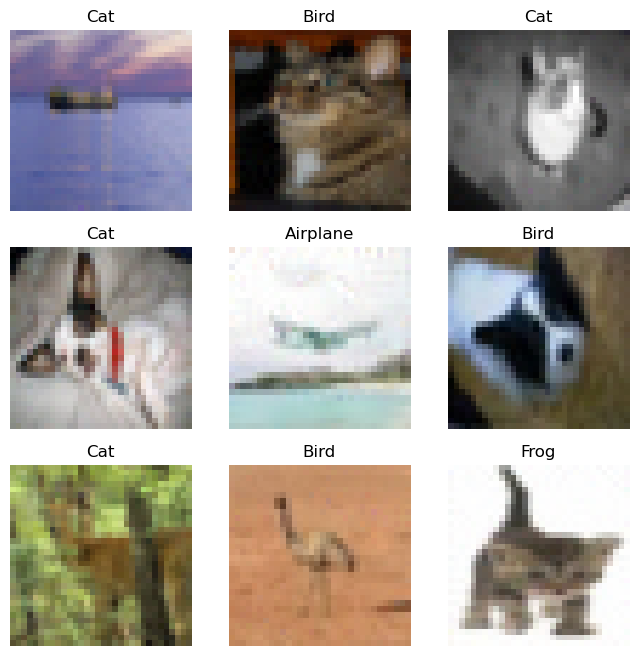

In [10]:
soft_max = nn.Softmax(dim=1)
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
Fragile_img = torch.load('./samples/cifar10/demonstrate_img')
Fragile_img = Fragile_img.detach().cpu()
target_model.eval()
Fragile_label = soft_max(target_model(Fragile_img.to(device))).argmax(1).detach().cpu().numpy()
# print(Fragile_label.shape)
for i in range(1, cols * rows + 1):
    img = Fragile_img[i-1]
    label = Fragile_label[i-1]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    img = img.permute(1,2,0)
    plt.imshow(img.squeeze())
plt.show()

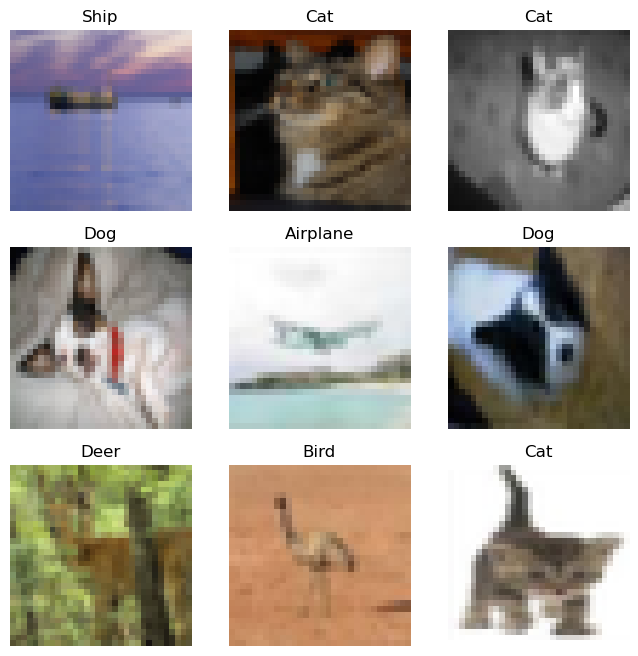

In [11]:
soft_max = nn.Softmax(dim=1)
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
target_model.eval()
Original_label = soft_max(target_model(Original_img.to(device))).argmax(1).detach().cpu().numpy()
# print(Fragile_label.shape)
for i in range(1, cols * rows + 1):
    img = Original_img[i-1]
    label = Original_label[i-1]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    img = img.permute(1,2,0)
    plt.imshow(img.squeeze())
plt.show()